<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2_complexes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold2_complexes

Credit to Minkyung Baek @minkbaek and Yoshitaka Moriwaki @Ag_smith for showing it works in alphafold2.
- https://twitter.com/minkbaek/status/1417538291709071362
- https://twitter.com/Ag_smith/status/1417063635000598528

- [script](https://github.com/RosettaCommons/RoseTTAFold/blob/main/example/complex_modeling/make_joint_MSA_bacterial.py) from rosettafold for paired alignment generation

In [20]:
#@title Input protein sequences
from google.colab import files
import os
import os.path
import re

query_sequence_a = 'AVLKIIQGALDTRELLKAYQEEACAKNFGAFCVFVGIVRKEDNIQGLSFDIYEALLKTWFEKWHHKAKDLGVVLKMAHSLGDVLIGQSSFLCVSMGKNRKNALELYENFIEDFKHNAPIWKYDLIHNKRIYAKERSHPLKGSGLLA' #@param {type:"string"}
query_sequence_a = "".join(query_sequence_a.split())
query_sequence_a = re.sub(r'[^a-zA-Z]','', query_sequence_a).upper()

query_sequence_b = 'MMVEVRFFGPIKEENFFIKANDLKELRAILQEKEGLKEWLGVCAIALNDHLIDNLNTPLKDGDVISLLPPVCGG' #@param {type:"string"}
query_sequence_b = "".join(query_sequence_b.split())
query_sequence_b = re.sub(r'[^a-zA-Z]','', query_sequence_b).upper()

query_sequence = query_sequence_a + query_sequence_b

jobname = '3RPF' #@param {type:"string"}
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)

with open(f"{jobname}_a.fasta", "w") as text_file:
    text_file.write(">1\n%s" % query_sequence_a)

with open(f"{jobname}_b.fasta", "w") as text_file:
    text_file.write(">1\n%s" % query_sequence_b)

# number of models to use
#@markdown ---
#@markdown ### Advanced settings
num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
msa_mode = "MMseqs2" #@param ["MMseqs2","single_sequence"]
use_msa = True if msa_mode == "MMseqs2" else False
pair_msa = True #@param {type:"boolean"}
#@markdown Note: for homodimers, might help to disable pair_msa

#@markdown ---
with open(f"{jobname}.log", "w") as text_file:
    text_file.write("num_models=%s\n" % num_models)
    text_file.write("use_msa=%s\n" % use_msa)
    text_file.write("msa_mode=%s\n" % msa_mode)
    text_file.write("pair_msa=%s\n" % pair_msa)

# decide which a3m to use
if use_msa:
  a3m_file_a = f"{jobname}_a.a3m"
  a3m_file_b = f"{jobname}_b.a3m"

In [21]:
#@title Install dependencies
%%bash -s $use_msa
USE_MSA=$1
if [ ! -f AF2_READY ]; then

  # install dependencies
  pip -q install biopython
  pip -q install dm-haiku
  pip -q install ml-collections
  pip -q install py3Dmol

  # download model
  if [ ! -d "alphafold/" ]; then
    git clone https://github.com/deepmind/alphafold.git --quiet
    mv alphafold alphafold_
    mv alphafold_/alphafold .
    # remove "END" from PDBs, otherwise biopython complains
    sed -i "s/pdb_lines.append('END')//" /content/alphafold/common/protein.py
    sed -i "s/pdb_lines.append('ENDMDL')//" /content/alphafold/common/protein.py
  fi

  # download model params (~1 min)
  if [ ! -d "params/" ]; then
    wget -qnc https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
    mkdir params
    tar -xf alphafold_params_2021-07-14.tar -C params/
    rm alphafold_params_2021-07-14.tar
  fi
  touch AF2_READY
fi
# download libraries for interfacing with MMseqs2 API
if [ ${USE_MSA} == "True" ]; then
  if [ ! -f MMSEQ2_READY ]; then
    apt-get -qq -y update 2>&1 1>/dev/null
    apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null
    touch MMSEQ2_READY
  fi
fi

In [22]:
#@title Call MMseqs2 to get MSA/templates
%%bash -s $use_msa $jobname
USE_MSA=$1
JOBNAME=$2
if [ ${USE_MSA} == "True" ]; then
  for C in "a" "b"
  do
    if [ ! -f ${JOBNAME}_${C}.mmseqs2.tar.gz ]; then
      # query MMseqs2 webserver
      echo "submitting job"
      ID=$(curl -s -F q=@${JOBNAME}_${C}.fasta -F mode=all https://a3m.mmseqs.com/ticket/msa | jq -r '.id')
      STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
      while [ "${STATUS}" == "RUNNING" ]; do
        STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
        sleep 1
      done
      if [ "${STATUS}" == "COMPLETE" ]; then
        curl -s https://a3m.mmseqs.com/result/download/${ID} > ${JOBNAME}_${C}.mmseqs2.tar.gz
        tar xzf ${JOBNAME}_${C}.mmseqs2.tar.gz
        tr -d '\000' < uniref.a3m > ${JOBNAME}_${C}.a3m
        rm uniref.a3m
        mv pdb70.m8 ${JOBNAME}_${C}.m8
      else
        echo "MMseqs2 server did not return a valid result."
        cp ${JOBNAME}_${C}.fasta ${JOBNAME}_${C}.a3m
      fi
    fi
    if [ ${USE_MSA} == "True" ]; then
      echo "Found $(grep -c ">" ${JOBNAME}_${C}.a3m) sequences (after redundacy filtering)"
    fi
  done
fi

Found 225 sequences (after redundacy filtering)
Found 232 sequences (after redundacy filtering)


In [23]:
#@title Import libraries and setup model
# setup the model
if "model" not in dir():

  # hiding warning messages
  import warnings
  from absl import logging
  import os
  import tensorflow as tf
  warnings.filterwarnings('ignore')
  logging.set_verbosity("error")
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  tf.get_logger().setLevel('ERROR')

  import sys
  import numpy as np
  import pickle
  from string import ascii_uppercase
  from alphafold.common import protein
  from alphafold.data import pipeline
  from alphafold.data import templates
  from alphafold.model import data
  from alphafold.model import config
  from alphafold.model import model
  from alphafold.data.tools import hhsearch

  # plotting libraries
  import py3Dmol
  import matplotlib.pyplot as plt
  import ipywidgets
  from ipywidgets import interact, fixed

def mk_mock_template(query_sequence):
  # since alphafold's model requires a template input
  # we create a blank example w/ zero input, confidence -1
  ln = len(query_sequence)
  output_templates_sequence = "-"*ln
  output_confidence_scores = np.full(ln,-1)
  templates_all_atom_positions = np.zeros((ln, templates.residue_constants.atom_type_num, 3))
  templates_all_atom_masks = np.zeros((ln, templates.residue_constants.atom_type_num))
  templates_aatype = templates.residue_constants.sequence_to_onehot(output_templates_sequence,
                                                                    templates.residue_constants.HHBLITS_AA_TO_ID)
  template_features = {'template_all_atom_positions': templates_all_atom_positions[None],
                       'template_all_atom_masks': templates_all_atom_masks[None],
                       'template_sequence': [f'none'.encode()],
                       'template_aatype': np.array(templates_aatype)[None],
                       'template_confidence_scores': output_confidence_scores[None],
                       'template_domain_names': [f'none'.encode()],
                       'template_release_date': [f'none'.encode()]}
  return template_features

def set_bfactor(pdb_filename, bfac, idx_res, chains):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[23:26].strip()) - 1
      seq_id = np.where(idx_res == seq_id)[0][0]
      O.write(f"{line[:21]}{chains[seq_id]}{line[22:60]}{bfac[seq_id]:6.2f}{line[66:]}")
  O.close()

def predict_structure(prefix, feature_dict, Ls, random_seed=0):  
  """Predicts structure using AlphaFold for the given sequence."""

  # Minkyung's code
  # add big enough number to residue index to indicate chain breaks
  idx_res = feature_dict['residue_index']
  L_prev = 0
  # Ls: number of residues in each chain
  for L_i in Ls[:-1]:
      idx_res[L_prev+L_i:] += 200
      L_prev += L_i  
  chains = list("".join([ascii_uppercase[n]*L for n,L in enumerate(Ls)]))

  feature_dict['residue_index'] = idx_res

  # Run the models.
  plddts = []
  unrelaxed_pdb_lines = []
  relaxed_pdb_lines = []

  for model_name, params in model_params.items():
    print(f"running {model_name}")
    # swap params to avoid recompiling
    # note: models 1,2 have diff number of params compared to models 3,4,5
    if any(str(m) in model_name for m in [1,2]): model_runner = model_runner_1
    if any(str(m) in model_name for m in [3,4,5]): model_runner = model_runner_3
    model_runner.params = params
    
    processed_feature_dict = model_runner.process_features(feature_dict, random_seed=random_seed)
    prediction_result = model_runner.predict(processed_feature_dict)
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
    unrelaxed_pdb_lines.append(protein.to_pdb(unrelaxed_protein))
    plddts.append(prediction_result['plddt'])

  # rerank models based on predicted lddt
  lddt_rank = np.mean(plddts,-1).argsort()[::-1]
  plddts_ranked = {}
  for n,r in enumerate(lddt_rank):
    print(f"model_{n+1} {np.mean(plddts[r])}")

    unrelaxed_pdb_path = f'{prefix}_unrelaxed_model_{n+1}.pdb'    
    with open(unrelaxed_pdb_path, 'w') as f: f.write(unrelaxed_pdb_lines[r])
    set_bfactor(unrelaxed_pdb_path,plddts[r]/100, idx_res, chains)

    plddts_ranked[f"model_{n+1}"] = plddts[r]

  return plddts_ranked

##################################
# CODE FROM MINKYUNG/ROSETTAFOLD
##################################
def read_a3m(fn):
    '''parse an a3m files as a dictionary {label->sequence}'''
    seq = []
    lab = []
    is_first = True
    for line in open(fn, "r"):
        if line[0] == '>':
            label = line.strip()[1:]
            is_incl = True
            if is_first: # include first sequence (query)
                is_first = False
                lab.append(label)
                continue
            if "UniRef" in label:
                code = label.split()[0].split('_')[-1]
                if code.startswith("UPI"): # UniParc identifier -- exclude
                    is_incl = False
                    continue
            elif label.startswith("tr|"):
                code = label.split('|')[1]
            else:
                is_incl = False
                continue
            lab.append(code)
        else:
            if is_incl:
                seq.append(line.rstrip())
            else:
                continue

    return seq, lab

# https://www.uniprot.org/help/accession_numbers
def uni2idx(ids):
    '''convert uniprot ids into integers according to the structure
    of uniprot accession numbers'''
    ids2 = [i+'AAA0' if len(i)==6 else i for i in ids]
    arr = np.array([list(s) for s in ids2], dtype='|S1').view(np.uint8)

    for i in [1,5,9]:
        arr[:,i] -= ord('0')

    arr[arr>=ord('A')] -= ord('A')
    arr[arr>=ord('0')] -= ord('0')-26

    arr[:,0][arr[:,0]>ord('Q')-ord('A')] -= 3

    arr = arr.astype(np.int64)

    coef = np.array([23,10,26,36,36,10,26,36,36,1], dtype=np.int64)
    coef = np.tile(coef[None,:],[len(ids),1])

    c1 = [i for i,id_ in enumerate(ids) if id_[0] in 'OPQ' and len(id_)==6]
    c2 = [i for i,id_ in enumerate(ids) if id_[0] not in 'OPQ' and len(id_)==6]

    coef[c1] = np.array([3, 10,36,36,36,1,1,1,1,1])
    coef[c2] = np.array([23,10,26,36,36,1,1,1,1,1])

    for i in range(1,10):
        coef[:,-i-1] *= coef[:,-i]

    return np.sum(arr*coef,axis=-1)

##########################
# DATABASE
##########################
if "model_params" not in dir(): model_params = {}
for model_name in ["model_1","model_2","model_3","model_4","model_5"][:num_models]:
  if model_name not in model_params:
    model_config = config.model_config(model_name)
    model_config.data.eval.num_ensemble = 1
    model_params[model_name] = data.get_model_haiku_params(model_name=model_name, data_dir=".")
    if model_name == "model_1":
      model_runner_1 = model.RunModel(model_config, model_params[model_name])
    if model_name == "model_3":
      model_runner_3 = model.RunModel(model_config, model_params[model_name])


In [24]:
#@title Gather input features, predict structure

Ls = [len(query_sequence_a),len(query_sequence_b)]
msas = []
deletion_matrices = []

# parse MSA
if pair_msa:
  ###########################################################################
  # CODE FROM MINKYUNG/ROSETTAFOLD
  ###########################################################################
  msa1, lab1 = read_a3m(a3m_file_a)
  msa2, lab2 = read_a3m(a3m_file_b)
  if len(lab1) > 1 and len(lab2) > 1:
    # convert uniprot ids into integers
    hash1 = uni2idx(lab1[1:])
    hash2 = uni2idx(lab2[1:])

    # find pairs of uniprot ids which are separated by at most 10
    idx1, idx2 = np.where(np.abs(hash1[:,None]-hash2[None,:]) < 10)
    if idx1.shape[0] > 0:
      a3m_lines = ['>query\n%s%s\n'%(msa1[0],msa2[0])]
      for i,j in zip(idx1,idx2):
        a3m_lines.append(">%s_%s\n%s%s\n"%(lab1[i+1],lab2[j+1],msa1[i+1],msa2[j+1]))
    msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(a3m_lines))
    msas.append(msa)
    deletion_matrices.append(deletion_matrix)

    print("pairs found:",len(msa))

if use_msa:
  a3m_lines = "".join(open(a3m_file_a,"r").readlines())
  msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines)
  msas.append([seq+"-"*Ls[1] for seq in msa])
  deletion_matrices.append([mtx+[0]*Ls[1] for mtx in deletion_matrix])

  a3m_lines = "".join(open(a3m_file_b,"r").readlines())
  msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines)
  msas.append(["-"*Ls[0]+seq for seq in msa])
  deletion_matrices.append([[0]*Ls[0]+mtx for mtx in deletion_matrix])

# gather features
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=msas, deletion_matrices=deletion_matrices),
    **mk_mock_template(query_sequence)
}
plddts = predict_structure(jobname, feature_dict, Ls=Ls)

pairs found: 16
running model_1
model_1 95.75224770824389


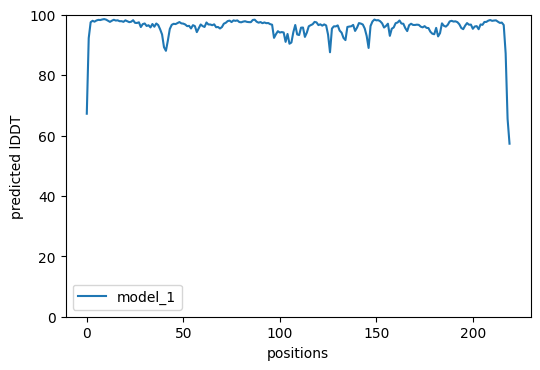

In [25]:
#@title Plot lDDT per residue
# confidence per position
plt.figure(dpi=100)
for model_name,value in plddts.items():
  plt.plot(value,label=model_name)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted lDDT")
plt.xlabel("positions")
plt.savefig(jobname+"_lDDT.png")
plt.show()

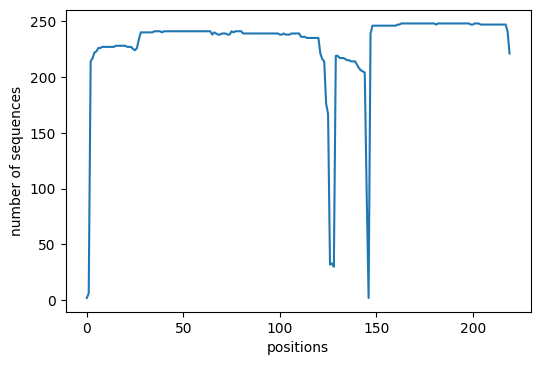

In [26]:
#@title Plot Number of Sequences per Position
# confidence per position
plt.figure(dpi=100)
plt.plot((feature_dict["msa"] != 21).sum(0))
plt.xlabel("positions")
plt.ylabel("number of sequences")
plt.savefig(jobname+"_msa_coverage.png")
plt.show()

In [27]:
#@title Show 3D structure
def show_pdb(model_name,
             show_sidechains=False,
             show_mainchain=False,
             color="chain"):

  def mainchain(p, color="white", model=0):
    BB = ['C','O','N','CA']
    p.addStyle({"model":model,'atom':BB},
                       {'stick':{'colorscheme':f"{color}Carbon",'radius':0.4}})

  def sidechain(p, model=0):
    HP = ["ALA","GLY","VAL","ILE","LEU","PHE","MET","PRO","TRP","CYS","TYR"]
    BB = ['C','O','N']
    p.addStyle({"model":model,'and':[{'resn':HP},{'atom':BB,'invert':True}]},
              {'stick':{'colorscheme':"yellowCarbon",'radius':0.4}})
    p.addStyle({"model":model,'and':[{'resn':"GLY"},{'atom':'CA'}]},
              {'sphere':{'colorscheme':"yellowCarbon",'radius':0.4}})
    p.addStyle({"model":model,'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
              {'stick':{'colorscheme':"yellowCarbon",'radius':0.4}})  
    p.addStyle({"model":model,'and':[{'resn':HP,'invert':True},{'atom':BB,'invert':True}]},
              {'stick':{'colorscheme':"whiteCarbon",'radius':0.4}})

  pdb_filename = f"{jobname}_unrelaxed_{model_name}.pdb"

  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open(pdb_filename,'r').read(),'pdb')
  if color == "lDDT":
    p.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':1}}})
  elif color == "rainbow":
    p.setStyle({'cartoon': {'color':'spectrum'}})
  else:
    p.setStyle({'chain':"A"},{'cartoon': {'color':'lime'}})
    p.setStyle({'chain':"B"},{'cartoon': {'color':'cyan'}})

  if show_sidechains: sidechain(p)
  if show_mainchain: mainchain(p)
  p.zoomTo()
  return p.show()

interact(show_pdb,
         model_name=ipywidgets.Dropdown(options=model_params.keys(), value='model_1'),
         show_sidechains=ipywidgets.Checkbox(value=False),
         show_mainchain=ipywidgets.Checkbox(value=False),
         color=ipywidgets.Dropdown(options=['chain', 'rainbow', 'lDDT'], value='chain'))

interactive(children=(Dropdown(description='model_name', options=('model_1',), value='model_1'), Checkbox(valu…

<function __main__.show_pdb>

In [28]:
#@title Package and download results
!zip -FSr $jobname".result.zip" $jobname".log" $jobname"_msa_coverage.png" $jobname"_"*"relaxed_model_"*".pdb" $jobname"_lDDT.png"
files.download(f"{jobname}.result.zip")

updating: 3RPF.log (deflated 7%)
updating: 3RPF_msa_coverage.png (deflated 7%)
updating: 3RPF_unrelaxed_model_1.pdb (deflated 78%)
updating: 3RPF_lDDT.png (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions
- If you having issues downloading results, try disable adblocker and run the last cell again. If that fails click on the little folder icon to the left, navigate to file:`jobname.result.zip`, right-click and select "download".